## Sckit Learn Machine Learning Models

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import pickle
import time

### Read data and remove outliers

In [2]:
df = pd.read_csv("./data/df_slow.csv")
summary = df["query_time_ns"]\
    .describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1.00])
mask = (df["query_time_ns"]<summary["99%"])
sum(mask)

df = df[mask]

X = df["clean_query"]
y = df['query_time_ns']
print(df.shape, X.shape, y.shape)

(15375, 4) (15375,) (15375,)


# Feature Extraction TF-IDF 
TF-IDF works by penalizing the common words by assigning them lower 
weights while giving importance to words which are rare in the entire 
corpus but appear in good numbers in few documents.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3)
xvalid, xtest, yvalid, ytest = train_test_split(xvalid, yvalid, test_size=0.3)
xtrain.shape, xvalid.shape, xtest.shape, ytrain.shape, yvalid.shape, ytest.shape

((10762,), (3229,), (1384,), (10762,), (3229,), (1384,))

### TfidfVectorizer have to fit only train data

In [5]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit(xtrain)

xtrain_tfidf = tfidf_vectorizer.transform(xtrain)
xvalid_tfidf = tfidf_vectorizer.transform(xvalid)
xtest_tfidf = tfidf_vectorizer.transform(xtest)

print("Number of features -tokens- in train set :", len(tfidf.get_feature_names()))

xtrain_tfidf.shape, xvalid_tfidf.shape, xtest_tfidf.shape, ytrain.shape, yvalid.shape, ytest.shape

Number of features -tokens- in train set : 876


((10762, 876), (3229, 876), (1384, 876), (10762,), (3229,), (1384,))

Don't need standadization since TfidfVectorizer combines all 
the options of CountVectorizer and TfidfTransformer in a single model

### Prepare a function to evaluate models

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

Create a function to evaluate each model. I will evaluate each model by size, prediction time, RMSE, MAE and r2 for train, validation and test sets.
The coefficient of determination: 1 is perfect prediction
r2  computes how much better the regression line fits the data 
than the mean line.
Another way to look at this formula is to compare the variance 
around the mean line to the variation around the regression line

In [7]:
def eval_model(model, x, y, data_type, prn = False):
    start = time.time()
    pred = model.predict(x)
    pred_time = np.round((time.time() - start),4)
    if prn:
        print(f"{data_type} - Root mean squared error     : {(mean_squared_error(y, pred, squared=False)):.2f}")
        print(f"{data_type} - Mean absolute error         : {(mean_absolute_error(y, pred)):.2f}")
        print(f"{data_type} - Coefficient of determination: {(r2_score(y, pred)):.2f}")
        print(f"{data_type} - Time elapsed                : {pred_time}\n")
    return np.round(mean_squared_error(y, pred, squared=False),1), \
            np.round(mean_absolute_error(y, pred),1), \
            np.round(r2_score(y, pred),2), \
            pred_time


Create a dataframe to collect results

In [8]:
# create a dataframe to collect the results if not already created
try:
    df_performance = pd.read_csv("./data/df_performance.csv")
    df_performance.set_index("Model", inplace=True)

except:
    df_performance = pd.DataFrame(columns=["Size", "Train RMSE", "Train MAE", "Train R2", "Time Elapsed",\
                                                  "Valid RMSE", "Valid MAE", "Valid R2", "Valid Elapsed",
                                                   "Test RMSE", "Test MAE", "Test R2", "Test Elapsed" ])


### Linear Regression

In [9]:
from sklearn  import linear_model

linreg = linear_model.LinearRegression()
linreg.fit(xtrain_tfidf, ytrain) 


LinearRegression()

In [10]:
model_name = "linreg"
p = pickle.dumps(eval(model_name))
model_size = sys.getsizeof(p)
print(f"{model_name} size                         : {model_size}")
tr_rmse, tr_mae, tr_r2, tr_time_elapsed  = eval_model(eval(model_name), xtrain_tfidf, ytrain, data_type="Train", prn = True)
val_rmse, val_mae, val_r2, val_time_elapsed  = eval_model(eval(model_name), xvalid_tfidf, yvalid, data_type="Valid", prn = True)
test_rmse, test_mae, test_r2, test_time_elapsed  = eval_model(eval(model_name), xtest_tfidf, ytest, data_type="Test", prn = True)

linreg size                         : 7432
Train - Root mean squared error     : 109958.57
Train - Mean absolute error         : 38663.77
Train - Coefficient of determination: 0.98
Train - Time elapsed                : 0.001

Valid - Root mean squared error     : 143922.26
Valid - Mean absolute error         : 51397.75
Valid - Coefficient of determination: 0.97
Valid - Time elapsed                : 0.0

Test - Root mean squared error     : 138415.11
Test - Mean absolute error         : 52290.40
Test - Coefficient of determination: 0.97
Test - Time elapsed                : 0.0



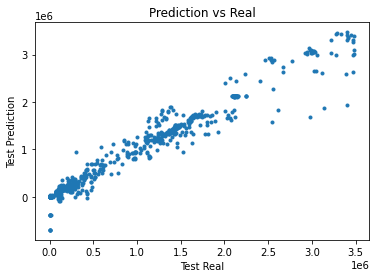

In [11]:
pred = linreg.predict(xtest_tfidf)
plt.plot(figsize=(10,5))
plt.plot(ytest, pred, ".")
plt.title("Prediction vs Real")
plt.xlabel("Test Real")
plt.ylabel("Test Prediction")
plt.show()


### Support Vector Regressor

In [12]:
from sklearn.svm import LinearSVR
svc_regr = LinearSVR(C=1, epsilon=0.05, max_iter=10000)
svc_regr.fit(xtrain_tfidf, ytrain)


LinearSVR(C=1, epsilon=0.05, max_iter=10000)

In [13]:
model_name = "svc_regr"
p = pickle.dumps(eval(model_name))
model_size = sys.getsizeof(p)
print(f"{model_name} size                         : {model_size}")
tr_rmse, tr_mae, tr_r2, tr_time_elapsed  = eval_model(eval(model_name), xtrain_tfidf, ytrain, data_type="Train", prn = True)
val_rmse, val_mae, val_r2, val_time_elapsed  = eval_model(eval(model_name), xvalid_tfidf, yvalid, data_type="Valid", prn = True)
test_rmse, test_mae, test_r2, test_time_elapsed  = eval_model(eval(model_name), xtest_tfidf, ytest, data_type="Test", prn = True)

svc_regr size                         : 7579
Train - Root mean squared error     : 888415.74
Train - Mean absolute error         : 422135.84
Train - Coefficient of determination: -0.29
Train - Time elapsed                : 0.0

Valid - Root mean squared error     : 881327.01
Valid - Mean absolute error         : 428619.07
Valid - Coefficient of determination: -0.31
Valid - Time elapsed                : 0.0

Test - Root mean squared error     : 910742.53
Test - Mean absolute error         : 446665.01
Test - Coefficient of determination: -0.31
Test - Time elapsed                : 0.001



### Below plow shows the performance of the model, another way of presenting r2 : Bad prediction

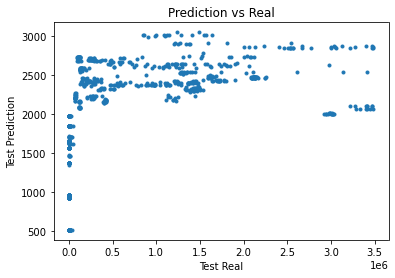

In [14]:
pred = svc_regr.predict(xtest_tfidf)
plt.plot(figsize=(10,5))
plt.plot(ytest, pred, ".")
plt.title("Prediction vs Real")
plt.xlabel("Test Real")
plt.ylabel("Test Prediction")
plt.show()

### Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor
rand_for_reg = RandomForestRegressor()
rand_for_reg.fit(xtrain_tfidf, ytrain)


RandomForestRegressor()

### Ada Boost Regressor

In [16]:
from sklearn.ensemble import AdaBoostRegressor
ada_boost_reg = AdaBoostRegressor()
ada_boost_reg.fit(xtrain_tfidf, ytrain)


AdaBoostRegressor()

### Gradient Boosting Regressor

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
grd_boost_reg = GradientBoostingRegressor()
grd_boost_reg.fit(xtrain_tfidf, ytrain)


GradientBoostingRegressor()

In [18]:
# !pip install xgboost

### XGB Regressor

In [19]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg.fit(xtrain_tfidf, ytrain)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Collect all models' performances

In [20]:
model_names = ["linreg", "svc_regr", "rand_for_reg", "ada_boost_reg", "grd_boost_reg", "xgb_reg"]
for model_name in model_names:
    p = pickle.dumps(eval(model_name))
    model_size = sys.getsizeof(p)
    print(f"{model_name} ..... completed")
    tr_rmse, tr_mae, tr_r2, tr_time_elapsed  = eval_model(eval(model_name), xtrain_tfidf, ytrain, data_type="Train")
    val_rmse, val_mae, val_r2, val_time_elapsed  = eval_model(eval(model_name), xvalid_tfidf, yvalid, data_type="Valid")
    test_rmse, test_mae, test_r2, test_time_elapsed  = eval_model(eval(model_name), xtest_tfidf, ytest, data_type="Test")
    df_performance.loc[model_name,:] = [model_size, tr_rmse, tr_mae, tr_r2, tr_time_elapsed,\
                                  val_rmse, val_mae, val_r2, val_time_elapsed,\
                                 test_rmse, test_mae, test_r2, test_time_elapsed]
df_performance

linreg ..... completed
svc_regr ..... completed
rand_for_reg ..... completed
ada_boost_reg ..... completed
grd_boost_reg ..... completed
xgb_reg ..... completed


,Size,Train RMSE,Train MAE,Train R2,Time Elapsed,Valid RMSE,Valid MAE,Valid R2,Valid Elapsed,Test RMSE,Test MAE,Test R2,Test Elapsed
Model,,,,,,,,,,,,,
linreg,7432,109958.6,38663.8,0.98,0.0016,143922.3,51397.7,0.97,0.0000,138415.1,52290.4,0.97,0.0000
svc_regr,7579,888415.7,422135.8,-0.29,0.0015,881327.0,428619.1,-0.31,0.0000,910742.5,446665.0,-0.31,0.0000
rand_for_reg,24770494,67211.8,20448.7,0.99,0.1519,134162.6,39441.2,0.97,0.0616,138995.7,42581.3,0.97,0.0275
ada_boost_reg,36763,219145.3,160038.5,0.92,0.0286,221945.0,161057.6,0.92,0.0103,231910.7,165048.4,0.91,0.0040
grd_boost_reg,120991,105024.1,39911.1,0.98,0.0120,130199.3,46705.4,0.97,0.0040,131216.3,48082.8,0.97,0.0040
xgb_reg,218927,70285.5,24723.6,0.99,0.0087,129252.8,38749.2,0.97,0.0041,132213.0,40272.0,0.97,0.0040


Save results for further comparison with keras models

In [21]:
df_performance.to_csv("./data/df_performance.csv",index_label='Model')